In [1]:
import os
import string

import torch
import torch.nn.functional as F

NAMES_FILE_PATH = os.path.join(os.getcwd(), 'src', 'names.txt')

In [2]:
with open(NAMES_FILE_PATH) as f:
    words = f.read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
stoi = {s:i for i, s in enumerate(string.ascii_lowercase[:26], 1)}
stoi['.'] = 0
itos = {i:s for s, i  in stoi.items()}

In [4]:
class NGramLanguageModel:
    stoi = stoi
    itos = itos
    def __init__(self, context = 3, embedding_dim = 2, learning_rate = 0.1, n_iters = 100000, batch_size = 32):
        self.context = context
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.embeddings = torch.randn((27, self.embedding_dim), requires_grad=True) 
        self.w1 = torch.randn((self.context * self.embedding_dim, 100), requires_grad=True)
        self.b1 = torch.randn(100, requires_grad=True)
        self.w2 = torch.randn((100,  27),  requires_grad=True)
        self.b2 = torch.randn(27, requires_grad=True)

    def __repr__(self):
        return f'NGramLanguageModel()'
    
    def _generate_dataset(self, words):
        X, Y = [], []
        for w in words:
            context =  [0] * self.context
            for ch in  w + '.':
                chi = self.stoi[ch]
                X.append(context)
                Y.append(chi)
                context = context[1:] + [chi]
        return torch.tensor(X), torch.tensor(Y)
    
    def _generate_batch(self, X, Y):
        samples_idx = torch.randint(0, X.shape[0], (self.batch_size,))
        return X[samples_idx], Y[samples_idx]
        
    def _forward(self, X):
        X = torch.tensor(X) if not isinstance(X, torch.Tensor) else X
        X = X.view(1, -1) if X.dim() == 1 else X
        h1 = torch.tanh(self.embeddings[X].view(X.shape[0], -1) @ self.w1 + self.b1)
        logits = h1 @ self.w2 + self.b2
        return logits
    
    def _predict(self, X):
        return F.softmax(self._forward(X))
    
    def _zero_grad(self):
        for p in self.parameters(): 
            p.grad = None
    
    def _step(self):
        for p in self.parameters(): 
            p.data -= self.learning_rate * p.grad

    def parameters(self):
        return [self.embeddings, self.w1, self.b1, self.w2, self.b2]
    
    def fit(self, words, verbose = True):
        X, Y = self._generate_dataset(words)
        for iteration in range(self.n_iters):
            X_batch, Y_batch = self._generate_batch(X, Y)
            probs = self._forward(X_batch)
            loss = F.cross_entropy(probs, Y_batch)
            if verbose and iteration % 10000 == 0: print(f'Iteration: {iteration} | Loss: {loss} | Generation: {self.generate()}')
            self._zero_grad()
            loss.backward()
            self._step()
            
    def generate(self, k = 5, maxlen = 10):
        generated_words = []
        for _ in range(k):
            context, generated_word, cur_len = [0] * self.context, [], 0
            while True and cur_len <= maxlen:
                next_char_prob_dist = self._predict(context)
                next_char_idx = torch.multinomial(next_char_prob_dist, 1, replacement=True).item()
                generated_word.append(self.itos[next_char_idx])
                if next_char_idx == 0:
                    break
                context = context[1:] + [next_char_idx]
                cur_len += 1
            if generated_word: generated_word.pop()
            generated_words.append(''.join(generated_word))
        return generated_words
    
model = NGramLanguageModel(context=4, embedding_dim=100, batch_size=1000, n_iters=200000)
model.fit(words)

C:\Users\User\AppData\Local\Temp\ipykernel_24092\984821858.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self._forward(X))


Iteration: 0 | Loss: 19.193639755249023 | Generation: ['qwmmakuwdr', 'qwmmwxgtja', 'qwmmakuwdr', 'qwmmakuwho', 'xeeuzhkrqd']
Iteration: 10000 | Loss: 2.2658419609069824 | Generation: ['hamarys', 'thyre', 'majaah', 'maxeriey', 'keegqice']
Iteration: 20000 | Loss: 2.2818973064422607 | Generation: ['tenn', 'jorna', 'juanibuh', 'gieliye', 'neel']
Iteration: 30000 | Loss: 2.1630799770355225 | Generation: ['karjielo', 'nauro', 'shayar', 'mokshygino', 'elia']
Iteration: 40000 | Loss: 2.1838176250457764 | Generation: ['ayra', 'audin', 'suriydaan', 'louh', 'ka']
Iteration: 50000 | Loss: 2.1498680114746094 | Generation: ['aiale', 'hunniri', 'delondh', 'graana', 'paerezinia']
Iteration: 60000 | Loss: 2.1417527198791504 | Generation: ['dulisa', 'ginda', 'hayvan', 'azare', 'ahaly']
Iteration: 70000 | Loss: 2.095111131668091 | Generation: ['rumalan', 'dory', 'mikdrah', 'draul', 'abbathaidy']
Iteration: 80000 | Loss: 2.19919490814209 | Generation: ['serlaoyd', 'fiido', 'edaminia', 'ashiden', 'mulin']

In [5]:

model.generate(20)

C:\Users\User\AppData\Local\Temp\ipykernel_24092\984821858.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self._forward(X))


['diasia',
 'auzlik',
 'innten',
 'hazesny',
 'harlin',
 'lebn',
 'tice',
 'ario',
 'syeki',
 'kolbe',
 'jaseee',
 'leid',
 'ryellisha',
 'joren',
 'javiyah',
 'seyane',
 'aboson',
 'dherrygs',
 'akysai',
 'novalen']

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
with torch.no_grad():
    embeddindgs_2d = pca.fit_transform(model.embeddings)

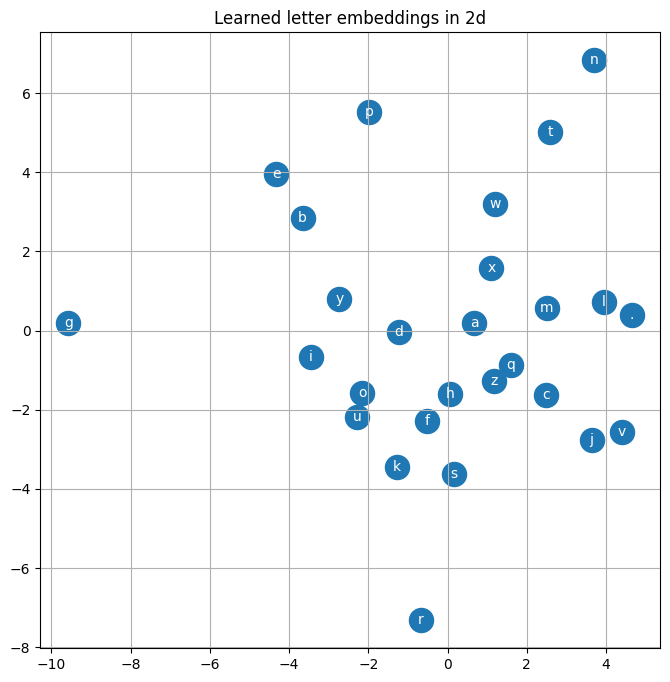

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.scatter(embeddindgs_2d[:, 0], embeddindgs_2d[:, 1], s=300)
for i in range(27):
    plt.text(embeddindgs_2d[i, 0], embeddindgs_2d[i, 1], itos[i], color='white', va='center', ha='center')
plt.grid('minor')
plt.title('Learned letter embeddings in 2d')
plt.show()